In [1]:
## Import necessary libraries

import numpy as np
import pandas as pd
import scipy as sc

from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split, KFold
# from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.neural_network import MLPClassifier

from tqdm import tqdm
from time import time
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [4]:
## Clean column data and create new columns to reflect that
def Df_Cleaner(df_):
    # Unchanged original df
    df = df_.copy(deep=True)

    ## Draft Number
    df['draft_number'].replace('Undrafted', last_draft+10, inplace=True) # Encode undrafted as last draft
    draft_number_list = df['draft_number'].astype('int64') # convert all strings to int
    ## Bin Draft numbers into highest multiple of 10 lower than them
    draft_number_list = np.array(draft_number_list)
    draft_number_list = np.floor(draft_number_list/10).astype(int) * 10
    draft_number_list = draft_number_list.tolist()
    df['draft_number'] = draft_number_list

    ## Draft Round
    df['draft_round'].replace('Undrafted', last_round+1, inplace=True) # Encode undrafted as last draft
    round_list = df['draft_round'].astype('int64') # convert all strings to int
    df['draft_round'] = round_list
    
    ## Draft year and season
    # Take the ending year of the season
    year_list = []
    for i, val in enumerate(df['season']):
        year_list.append(int(val.split('-')[0]) + 1)
    df['year_list'] = year_list

    # Convert undrafted to 0 for draft_year
    df['draft_year'].replace('Undrafted', 0, inplace=True)
    draft_year_list = df['draft_year'].astype('int64') # Convert all years into int type
    df['draft_year'] = draft_year_list
    
    # Count experience
    df['Experience'] = df['year_list'] - df['draft_year']
    # Make undrafted values back to zero (for neutral math effect)
    exp_list = []
    for i, val in enumerate(df['Experience']):
        if val > 100:
            exp_list.append(0)
        else:
            exp_list.append(int(val))
    # Ensure experience is int type
    df['Experience'] = exp_list
 
    ## Drop draft number and draft year columns
    df.drop(['player_name', 'draft_year', 'season', 'year_list'], axis=1, inplace=True)

    return df

## Preprocess all columns
def Df_RegOneHot(df_):
    # Unchanged original df
    df = df_.copy(deep=True)

    # Columns for one-hot encoding
    df = pd.get_dummies(data=df, columns=['team_abbreviation', 'college', 'country'])
    
    # # MinMax Scaling
    # mm_scaler = MinMaxScaler()
    # df[mm_cols] = mm_scaler.fit_transform(df[mm_cols])

    # # Robust Scaling
    # rb_scaler = RobustScaler()
    # df[rb_cols] = rb_scaler.fit_transform(df[rb_cols])

    return df 

In [5]:
# Read into the training dataframe
df_all = pd.read_csv('NBA_player_datasets/NBA_player_stats_all.csv', index_col=[0])
df_all.head()

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,Dennis Rodman,CHI,36.0,198.12,99.790240,Southeastern Oklahoma State,USA,1986,2,27,...,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,1996-97
1,Dwayne Schintzius,LAC,28.0,215.90,117.933920,Florida,USA,1990,1,24,...,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,1996-97
2,Earl Cureton,TOR,39.0,205.74,95.254320,Detroit Mercy,USA,1979,3,58,...,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,1996-97
3,Ed O'Bannon,DAL,24.0,203.20,100.697424,UCLA,USA,1995,1,9,...,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,1996-97
4,Ed Pinckney,MIA,34.0,205.74,108.862080,Villanova,USA,1985,1,10,...,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,1996-97


In [6]:
df_aux = df_all.copy(deep=True)

df_aux['draft_number'].replace('Undrafted', 0, inplace=True)
df_aux['draft_number'] = df_aux['draft_number'].astype('int64')
df_aux['draft_round'].replace('Undrafted', 0, inplace=True)
df_aux['draft_round'] = df_aux['draft_round'].astype('int64')
last_draft = max(df_aux['draft_number'])
last_round = max(df_aux['draft_round'])
last_draft, last_round

(165, 8)

In [7]:
# Clean the training dataframe
df_all_cleaned = Df_Cleaner(df_all)
df_all_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12305 entries, 0 to 12304
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   team_abbreviation  12305 non-null  object 
 1   age                12305 non-null  float64
 2   player_height      12305 non-null  float64
 3   player_weight      12305 non-null  float64
 4   college            12305 non-null  object 
 5   country            12305 non-null  object 
 6   draft_round        12305 non-null  int64  
 7   draft_number       12305 non-null  int64  
 8   gp                 12305 non-null  int64  
 9   pts                12305 non-null  float64
 10  reb                12305 non-null  float64
 11  ast                12305 non-null  float64
 12  net_rating         12305 non-null  float64
 13  oreb_pct           12305 non-null  float64
 14  dreb_pct           12305 non-null  float64
 15  usg_pct            12305 non-null  float64
 16  ts_pct             123

In [8]:
# Perform Preprocessing
df_all_preproc = Df_RegOneHot(df_all_cleaned)
df_all_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12305 entries, 0 to 12304
Columns: 481 entries, age to country_Yugoslavia
dtypes: float64(12), int64(4), uint8(465)
memory usage: 7.1 MB


In [9]:
# Separate X and y from train data
df_X = df_all_preproc.drop(['draft_round', 'draft_number'], axis=1)
df_y = df_all_preproc[['draft_round', 'draft_number']].copy()

# Convert to numpy arrays for ML
np_X = df_X.to_numpy()
np_y = df_y.to_numpy()
np_X.shape, np_y.shape

((12305, 479), (12305, 2))

In [10]:
# For the non one-hot encoded features
marker = 14

In [11]:
np_X_train, np_X_test, np_y_train, np_y_test = train_test_split(np_X, np_y, \
                                                                test_size=0.2, random_state=42)

np_round_train, np_round_test = np_y_train[:, 0], np_y_test[:, 0]
np_num_train, np_num_test = np_y_train[:, 1], np_y_test[:, 1]

In [12]:
def ScaleCols(X, marker, mns=None, rngs=None):
    if mns == None and rngs == None:
        mns = []
        rngs = []
        for i in range(marker):
            X[:, i] = (X[:, i] - np.mean(X[:, i])) / (np.max(X[:, i]) - np.min(X[:, i]))
            mns.append(np.mean(X[:, i]))
            rngs.append((np.max(X[:, i]) - np.min(X[:, i])))
        return X, mns, rngs
    else:
        for i in range(marker):
            X[:, i] = (X[:, i] - mns[i]) / rngs[i]
        return X, mns, rngs


In [13]:
np_X_train, mn_X, rng_X = ScaleCols(X=np_X_train, marker=marker)
np_X_test, _, _ = ScaleCols(X=np_X_test, marker=marker)

In [14]:
# Function for plotting confusion matrix
def PlotConfMat(conf_mat):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(x=i, y=j, s=conf_mat[i, j], va='center', ha='center')
    
    plt.xlabel('Actual', fontsize=18)
    plt.ylabel('Predicted', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

def PolynomialTransforms(X, marker, degree=1):
    poly_fts = PolynomialFeatures(degree)
    poly_X = poly_fts.fit_transform(X[:, :marker])     # apply transforms to certain columns
    X_fin = np.hstack((poly_X, X[:, marker:]))
    return X_fin

TRAINING
Draft Round Accuracy = 0.4235067045916294
Draft Stage Accuracy = 0.1702559934985778
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.11097602933273044
Draft Stage Macro-F1 =  0.078113016089161
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


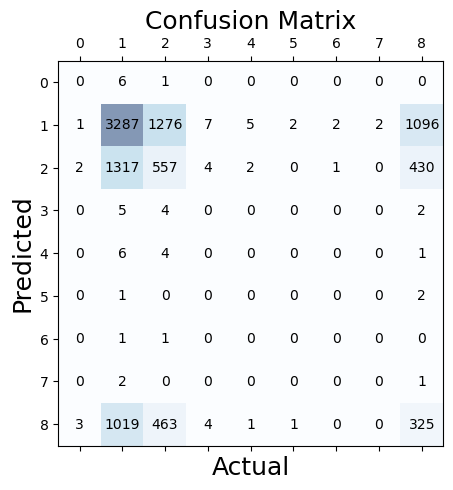

Draft Stage Conf. Mat.


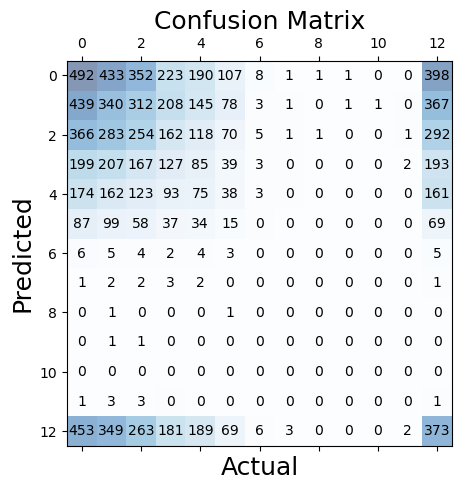

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
Draft Round Accuracy = 0.41162129215765947
Draft Stage Accuracy = 0.16416091019910606
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.12157234642383158
Draft Stage Macro-F1 =  0.08568482435268945
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


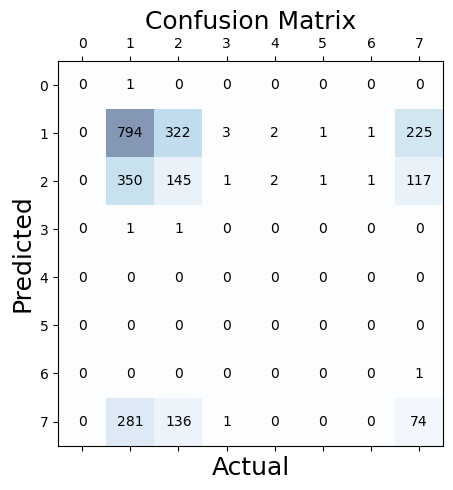

Draft Stage Conf. Mat.


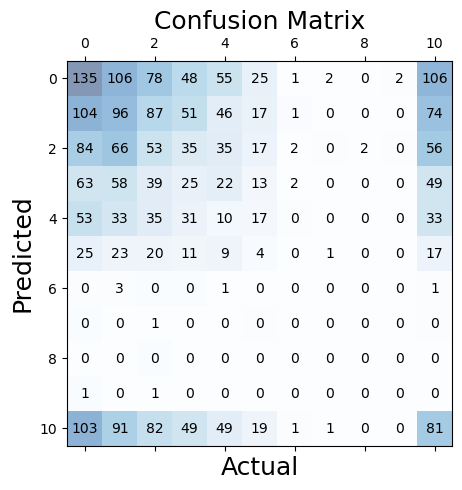

In [15]:
## Trivial System

# Get simple priors
round_unique, round_counts = np.unique(np_round_train, return_counts=True)
round_priors = round_counts / len(np_round_train)

num_unique, num_counts = np.unique(np_num_train, return_counts=True)
num_priors = num_counts / len(np_num_train)

# Training data

np_round_pred = np.empty_like(np_round_train)
np_num_pred = np.empty_like(np_num_train)
for i in range(len(np_round_pred)):
    np_round_pred[i] = np.random.choice(round_unique, p=round_priors)
    np_num_pred[i] = np.random.choice(num_unique, p=num_priors)

print("TRAINING")
# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_train, np_round_pred)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_train, np_num_pred)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_train, np_round_pred, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_train, np_num_pred, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_train, np_round_pred))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_train, np_num_pred))
print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

# Testing Data

np_round_pred = np.empty_like(np_round_test)
np_num_pred = np.empty_like(np_num_test)
for i in range(len(np_round_pred)):
    np_round_pred[i] = np.random.choice(round_unique, p=round_priors)
    np_num_pred[i] = np.random.choice(num_unique, p=num_priors)

print("TESTING")
# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_test, np_round_pred)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_test, np_num_pred)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_test, np_round_pred, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_test, np_num_pred, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_test, np_round_pred))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_test, np_num_pred))

TRAINING
Draft Round Accuracy = 0.5351483136936205
Draft Stage Accuracy = 0.3473181633482324
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.35146633706224034
Draft Stage Macro-F1 =  0.2558427721272855
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


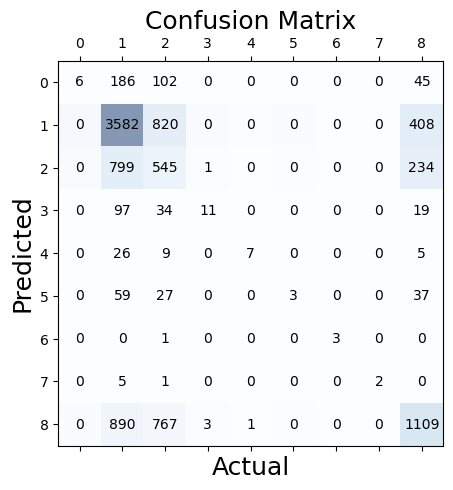

Draft Stage Conf. Mat.


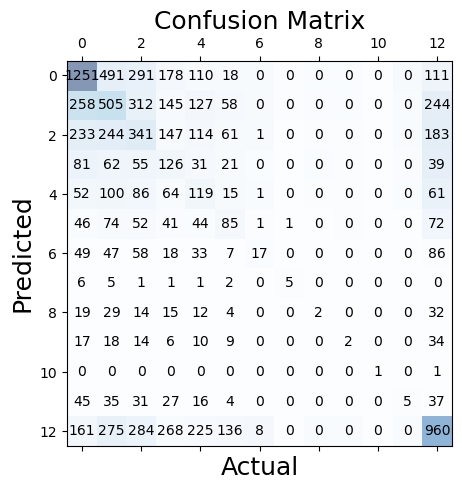

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
Draft Round Accuracy = 0.5481511580658269
Draft Stage Accuracy = 0.36164160910199106
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.313482744501163
Draft Stage Macro-F1 =  0.20644110262991378
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


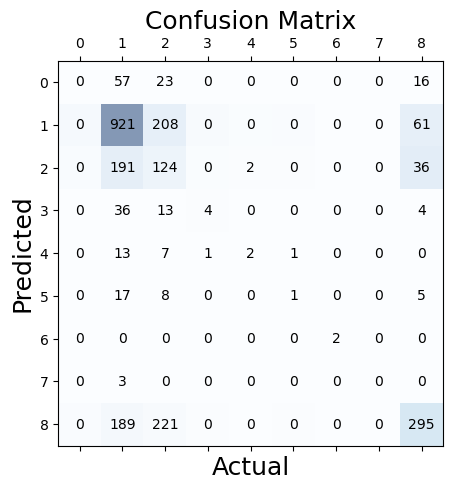

Draft Stage Conf. Mat.


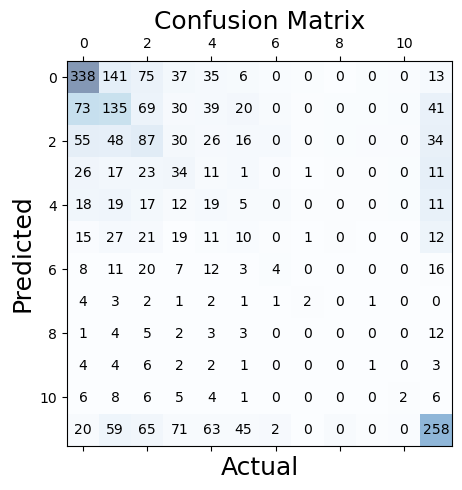

In [16]:
## Baseline System - Nearest Means

clf_round = NearestCentroid()
clf_round.fit(np_X_train, np_round_train)

clf_num = NearestCentroid()
clf_num.fit(np_X_train, np_num_train)

# Training data

np_round_pred = clf_round.predict(np_X_train)
np_num_pred = clf_num.predict(np_X_train)

print("TRAINING")
# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_train, np_round_pred)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_train, np_num_pred)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_train, np_round_pred, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_train, np_num_pred, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_train, np_round_pred))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_train, np_num_pred))
print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

# Testing Data

np_round_pred = clf_round.predict(np_X_test)
np_num_pred = clf_num.predict(np_X_test)

print("TESTING")
# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_test, np_round_pred)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_test, np_num_pred)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_test, np_round_pred, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_test, np_num_pred, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_test, np_round_pred))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_test, np_num_pred))

In [17]:
# ## Multinomial Ridge Classifier - OvR

# degrees = [3, 4, 5]
# lamdas = [1e-3, 3e-3, 0.01]

# # best_params_round = {'degree': 1, 'lamda': 0}
# # best_params_num = {'degree': 1, 'lamda': 0}
# best_params_round = {'degree': 4, 'lamda': 0.01}
# best_params_num = {'degree': 4, 'lamda': 0.001}

# # # to isolate best model
# # best_acc_round = 0
# # best_acc_num = 0
# # counter=0
# # for degree in degrees:
# #     for lamda in lamdas:
# #         counter+=1
# #         print(counter)
# #         clf = OneVsRestClassifier(RidgeClassifier(alpha=lamda))
        
# #         X_train, X_val, y_train, y_val = train_test_split(np_X_train, np_y_train, \
# #                                                         test_size=0.2, random_state=42)
# #         X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
# #         X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)
        
# #         X_train = PolynomialTransforms(X_train, marker, degree=degree)
# #         X_val = PolynomialTransforms(X_val, marker, degree=degree)
        
# #         # Draft Round
# #         round_train, round_val = y_train[:, 0], y_val[:, 0]
# #         clf.fit(X_train, round_train)
# #         round_pred = clf.predict(X_val)
# #         # Decide on Accuracy
# #         acc_round = accuracy_score(round_val, round_pred)
# #         if (acc_round > best_acc_round):
# #             best_acc_round = acc_round
# #             best_params_round['degree'] = degree
# #             best_params_round['lamda'] = lamda

# #         # Draft Stage
# #         num_train, num_val = y_train[:, 1], y_val[:, 1]
# #         clf.fit(X_train, num_train)
# #         num_pred = clf.predict(X_val)
# #         # Decide on Accuracy
# #         acc_num = accuracy_score(num_val, num_pred)
# #         if (acc_num > best_acc_num):
# #             best_acc_num = acc_num
# #             best_params_num['degree'] = degree
# #             best_params_num['lamda'] = lamda

# print("Best Params for Draft Round =", best_params_round)
# print("Best Params for Draft Stage =", best_params_num)

In [18]:
# ## Results

# # Draft Round
# reg_round = OneVsRestClassifier(RidgeClassifier(alpha=best_params_round['lamda']))
# np_X1_train = PolynomialTransforms(np_X_train, marker, degree=best_params_round['degree'])
# np_X1_test = PolynomialTransforms(np_X_test, marker, degree=best_params_round['degree'])
# reg_round.fit(np_X1_train, np_round_train)
# # Draft Stage
# reg_num = OneVsRestClassifier(RidgeClassifier(alpha=best_params_num['lamda']))
# np_X2_train = PolynomialTransforms(np_X_train, marker, degree=best_params_num['degree'])
# np_X2_test = PolynomialTransforms(np_X_test, marker, degree=best_params_num['degree'])
# reg_num.fit(np_X2_train, np_num_train)

# print('TRAINING')
# round_reg = reg_round.predict(np_X1_train)
# num_reg = reg_num.predict(np_X2_train)

# # Accuracy
# print(f'Draft Round Accuracy = {accuracy_score(np_round_train, round_reg)}')
# print(f'Draft Stage Accuracy = {accuracy_score(np_num_train, num_reg)}')
# print("-------------------------------------------------------------------------------------")
# # Macro F1
# print('Draft Round Macro-F1 = ', f1_score(np_round_train, round_reg, average='macro'))
# print('Draft Stage Macro-F1 = ', f1_score(np_num_train, num_reg, average='macro'))
# print("-------------------------------------------------------------------------------------")
# # Confusion Matrix
# print('Draft Round Conf. Mat.')  
# PlotConfMat(confusion_matrix(np_round_train, round_reg))
# print('Draft Stage Conf. Mat.') 
# PlotConfMat(confusion_matrix(np_num_train, num_reg))
# print("-------------------------------------------------------------------------------------")
# print("-------------------------------------------------------------------------------------")

# print('TESTING')
# round_reg = reg_round.predict(np_X1_test)
# num_reg = reg_num.predict(np_X2_test)

# # Accuracy
# print(f'Draft Round Accuracy = {accuracy_score(np_round_test, round_reg)}')
# print(f'Draft Stage Accuracy = {accuracy_score(np_num_test, num_reg)}')
# print("-------------------------------------------------------------------------------------")
# # Macro F1
# print('Draft Round Macro-F1 = ', f1_score(np_round_test, round_reg, average='macro'))
# print('Draft Stage Macro-F1 = ', f1_score(np_num_test, num_reg, average='macro'))
# print("-------------------------------------------------------------------------------------")
# # Confusion Matrix
# print('Draft Round Conf. Mat.')  
# PlotConfMat(confusion_matrix(np_round_test, round_reg))
# print('Draft Stage Conf. Mat.') 
# PlotConfMat(confusion_matrix(np_num_test, num_reg))

In [19]:
# ##Support Vector Classifier - OvR

# # best_params_round = {'kernel': 'linear', 'degree': 1, 'gamma': 10, 'C': 1}
# # best_params_num = {'kernel': 'linear', 'degree': 1, 'gamma': 10, 'C': 1}
# best_params_round = {'kernel': 'poly', 'degree': 4, 'gamma': 3, 'C': 0.01}
# best_params_num = {'kernel': 'poly', 'degree': 4, 'gamma': 3, 'C': 0.01}

# # # grids for search 
# # kernels = ['rbf', 'sigmoid', 'poly']
# # degrees = [3, 4, 5]
# # gammas = [0.3, 1, 3]
# # Cs = [0.01, 0.03, 0.1]

# # # to isolate best model
# # best_acc_round = 0
# # best_acc_num = 0
# # counter = 0
# # for kernel in kernels:
# #     for gamma in gammas:
# #         for C in Cs:
# #             for degree in degrees:
# #                 Breaker = True
# #                 if kernel == 'poly':
# #                     Breaker = False
# #                 counter+=1
# #                 print(counter)
# #                 clf = OneVsRestClassifier(SVC(C=C, kernel=kernel, degree=degree, gamma=gamma))
# #                 X_train, X_val, y_train, y_val = train_test_split(np_X_train, np_y_train, \
# #                                                                     test_size=0.2, random_state=42)
# #                 X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
# #                 X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)
                
# #                 # Draft Round
# #                 round_train, round_val = y_train[:, 0], y_val[:, 0]
# #                 clf.fit(X_train, round_train)
# #                 round_pred = clf.predict(X_val)
# #                 # Decide on Accuracy
# #                 acc_round = accuracy_score(round_val, round_pred)
# #                 if (acc_round > best_acc_round):
# #                     best_acc_round = acc_round
# #                     best_params_round['kernel'] = kernel
# #                     best_params_round['degree'] = degree
# #                     best_params_round['gamma'] = gamma
# #                     best_params_round['C'] = C

# #                 # Draft Stage
# #                 num_train, num_val = y_train[:, 1], y_val[:, 1]
# #                 clf.fit(X_train, num_train)
# #                 num_pred = clf.predict(X_val)
# #                 # Decide on Accuracy
# #                 acc_num = accuracy_score(num_val, num_pred)
# #                 if (acc_num > best_acc_num):
# #                     best_acc_num = acc_num
# #                     best_params_num['kernel'] = kernel
# #                     best_params_num['degree'] = degree
# #                     best_params_num['gamma'] = gamma
# #                     best_params_num['C'] = C

# print("Best Params for Draft Round =", best_params_round)
# print("Best Params for Draft Stage =", best_params_num)

In [20]:
# ## Results

# # Draft Round
# svc_round = OneVsRestClassifier(SVC(kernel=best_params_round['kernel'], degree=best_params_round['degree'],\
#                                     gamma=best_params_round['gamma'], C=best_params_round['C']))
# svc_round.fit(np_X_train, np_round_train)
# # Draft Stage
# svc_num = OneVsRestClassifier(SVC(kernel=best_params_round['kernel'], degree=best_params_round['degree'],\
#                                     gamma=best_params_round['gamma'], C=best_params_round['C']))
# svc_num.fit(np_X_train, np_num_train)

# print('TRAINING')
# round_svc = svc_round.predict(np_X_train)
# num_svc = svc_num.predict(np_X_train)

# # Accuracy
# print(f'Draft Round Accuracy = {accuracy_score(np_round_train, round_svc)}')
# print(f'Draft Stage Accuracy = {accuracy_score(np_num_train, num_svc)}')
# print("-------------------------------------------------------------------------------------")
# # Macro F1
# print('Draft Round Macro-F1 = ', f1_score(np_round_train, round_svc, average='macro'))
# print('Draft Stage Macro-F1 = ', f1_score(np_num_train, num_svc, average='macro'))
# print("-------------------------------------------------------------------------------------")
# # Confusion Matrix
# print('Draft Round Conf. Mat.')  
# PlotConfMat(confusion_matrix(np_round_train, round_svc))
# print('Draft Stage Conf. Mat.') 
# PlotConfMat(confusion_matrix(np_num_train, num_svc))
# print("-------------------------------------------------------------------------------------")
# print("-------------------------------------------------------------------------------------")

# print('TESTING')
# round_svc = svc_round.predict(np_X_test)
# num_svc = svc_num.predict(np_X_test)

# # Accuracy
# print(f'Draft Round Accuracy = {accuracy_score(np_round_test, round_svc)}')
# print(f'Draft Stage Accuracy = {accuracy_score(np_num_test, num_svc)}')
# print("-------------------------------------------------------------------------------------")
# # Macro F1
# print('Draft Round Macro-F1 = ', f1_score(np_round_test, round_svc, average='macro'))
# print('Draft Stage Macro-F1 = ', f1_score(np_num_test, num_svc, average='macro'))
# print("-------------------------------------------------------------------------------------")
# # Confusion Matrix
# print('Draft Round Conf. Mat.')  
# PlotConfMat(confusion_matrix(np_round_test, round_svc))
# print('Draft Stage Conf. Mat.') 
# PlotConfMat(confusion_matrix(np_num_test, num_svc))

In [21]:
# ## KNN Classifier

# Ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]

# best_params_round = {'K': 1}
# best_params_num = {'K': 1}

# # to isolate best model
# best_acc_round = 0
# best_acc_num = 0

# for K in Ks:
#     clf = KNeighborsClassifier(n_neighbors=K)
    
#     X_train, X_val, y_train, y_val = train_test_split(np_X_train, np_y_train, \
#                                                     test_size=0.2, random_state=42)
#     X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
#     X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)
    
    
#     # Draft Round
#     round_train, round_val = y_train[:, 0], y_val[:, 0]
#     clf.fit(X_train, round_train)
#     round_pred = clf.predict(X_val)
#     # Decide on Accuracy
#     acc_round = accuracy_score(round_val, round_pred)
#     if (acc_round > best_acc_round):
#         best_acc_round = acc_round
#         best_params_round['K'] = K

#     # Draft Stage
#     num_train, num_val = y_train[:, 1], y_val[:, 1]
#     clf.fit(X_train, num_train)
#     num_pred = clf.predict(X_val)
#     # Decide on Accuracy
#     acc_num = accuracy_score(num_val, num_pred)
#     if (acc_num > best_acc_num):
#         best_acc_num = acc_num
#         best_params_num['K'] = K
        
# print("Best Params for Draft Round =", best_params_round)
# print("Best Params for Draft Stage =", best_params_num)

In [22]:
# ## Results

# # Draft Round
# knn_round = KNeighborsClassifier(n_neighbors=best_params_round['K'])
# knn_round.fit(np_X_train, np_round_train)
# # Draft Stage
# knn_num = KNeighborsClassifier(n_neighbors=best_params_num['K'])
# knn_num.fit(np_X_train, np_num_train)

# print('TRAINING')
# round_knn = knn_round.predict(np_X_train)
# num_knn = knn_num.predict(np_X_train)

# # Accuracy
# print(f'Draft Round Accuracy = {accuracy_score(np_round_train, round_knn)}')
# print(f'Draft Stage Accuracy = {accuracy_score(np_num_train, num_knn)}')
# print("-------------------------------------------------------------------------------------")
# # Macro F1
# print('Draft Round Macro-F1 = ', f1_score(np_round_train, round_knn, average='macro'))
# print('Draft Stage Macro-F1 = ', f1_score(np_num_train, num_knn, average='macro'))
# print("-------------------------------------------------------------------------------------")
# # Confusion Matrix
# print('Draft Round Conf. Mat.')  
# PlotConfMat(confusion_matrix(np_round_train, round_knn))
# print('Draft Stage Conf. Mat.') 
# PlotConfMat(confusion_matrix(np_num_train, num_knn))
# print("-------------------------------------------------------------------------------------")
# print("-------------------------------------------------------------------------------------")

# print('TESTING')
# round_knn = knn_round.predict(np_X_test)
# num_knn = knn_num.predict(np_X_test)

# # Accuracy
# print(f'Draft Round Accuracy = {accuracy_score(np_round_test, round_knn)}')
# print(f'Draft Stage Accuracy = {accuracy_score(np_num_test, num_knn)}')
# print("-------------------------------------------------------------------------------------")
# # Macro F1
# print('Draft Round Macro-F1 = ', f1_score(np_round_test, round_knn, average='macro'))
# print('Draft Stage Macro-F1 = ', f1_score(np_num_test, num_knn, average='macro'))
# print("-------------------------------------------------------------------------------------")
# # Confusion Matrix
# print('Draft Round Conf. Mat.')  
# PlotConfMat(confusion_matrix(np_round_test, round_knn))
# print('Draft Stage Conf. Mat.') 
# PlotConfMat(confusion_matrix(np_num_test, num_knn))

In [23]:
# ## Naive Bayes Classifier

# nb_round = GaussianNB()
# nb_round.fit(np_X_train, np_round_train)

# nb_num = GaussianNB()
# nb_num.fit(np_X_train, np_num_train)

# # Training data

# np_round_pred = nb_round.predict(np_X_train)
# np_num_pred = nb_num.predict(np_X_train)

# print("TRAINING")
# # Accuracy
# print(f'Draft Round Accuracy = {accuracy_score(np_round_train, np_round_pred)}')
# print(f'Draft Stage Accuracy = {accuracy_score(np_num_train, np_num_pred)}')
# print("-------------------------------------------------------------------------------------")
# # Macro F1
# print('Draft Round Macro-F1 = ', f1_score(np_round_train, np_round_pred, average='macro'))
# print('Draft Stage Macro-F1 = ', f1_score(np_num_train, np_num_pred, average='macro'))
# print("-------------------------------------------------------------------------------------")
# # Confusion Matrix
# print('Draft Round Conf. Mat.')  
# PlotConfMat(confusion_matrix(np_round_train, np_round_pred))
# print('Draft Stage Conf. Mat.') 
# PlotConfMat(confusion_matrix(np_num_train, np_num_pred))
# print("-------------------------------------------------------------------------------------")
# print("-------------------------------------------------------------------------------------")

# # Testing Data

# np_round_pred = nb_round.predict(np_X_test)
# np_num_pred = nb_num.predict(np_X_test)

# print("TESTING")
# # Accuracy
# print(f'Draft Round Accuracy = {accuracy_score(np_round_test, np_round_pred)}')
# print(f'Draft Stage Accuracy = {accuracy_score(np_num_test, np_num_pred)}')
# print("-------------------------------------------------------------------------------------")
# # Macro F1
# print('Draft Round Macro-F1 = ', f1_score(np_round_test, np_round_pred, average='macro'))
# print('Draft Stage Macro-F1 = ', f1_score(np_num_test, np_num_pred, average='macro'))
# print("-------------------------------------------------------------------------------------")
# # Confusion Matrix
# print('Draft Round Conf. Mat.')  
# PlotConfMat(confusion_matrix(np_round_test, np_round_pred))
# print('Draft Stage Conf. Mat.') 
# PlotConfMat(confusion_matrix(np_num_test, np_num_pred))

In [24]:
# ## Complement Naive Bayes Classifier

# # Use MinMaxScaler for acceptable input into Complement NB

# sc = MinMaxScaler()
# np_X1_train = sc.fit_transform(np_X_train)
# np_X1_test = sc.fit_transform(np_X_test)


# nb_round = ComplementNB()
# nb_round.fit(np_X1_train, np_round_train)

# nb_num = ComplementNB()
# nb_num.fit(np_X1_train, np_num_train)

# # Training data

# np_round_pred = nb_round.predict(np_X1_train)
# np_num_pred = nb_num.predict(np_X1_train)

# print("TRAINING")
# # Accuracy
# print(f'Draft Round Accuracy = {accuracy_score(np_round_train, np_round_pred)}')
# print(f'Draft Stage Accuracy = {accuracy_score(np_num_train, np_num_pred)}')
# print("-------------------------------------------------------------------------------------")
# # Macro F1
# print('Draft Round Macro-F1 = ', f1_score(np_round_train, np_round_pred, average='macro'))
# print('Draft Stage Macro-F1 = ', f1_score(np_num_train, np_num_pred, average='macro'))
# print("-------------------------------------------------------------------------------------")
# # Confusion Matrix
# print('Draft Round Conf. Mat.')  
# PlotConfMat(confusion_matrix(np_round_train, np_round_pred))
# print('Draft Stage Conf. Mat.') 
# PlotConfMat(confusion_matrix(np_num_train, np_num_pred))
# print("-------------------------------------------------------------------------------------")
# print("-------------------------------------------------------------------------------------")

# # Testing Data

# np_round_pred = nb_round.predict(np_X1_test)
# np_num_pred = nb_num.predict(np_X1_test)

# print("TESTING")
# # Accuracy
# print(f'Draft Round Accuracy = {accuracy_score(np_round_test, np_round_pred)}')
# print(f'Draft Stage Accuracy = {accuracy_score(np_num_test, np_num_pred)}')
# print("-------------------------------------------------------------------------------------")
# # Macro F1
# print('Draft Round Macro-F1 = ', f1_score(np_round_test, np_round_pred, average='macro'))
# print('Draft Stage Macro-F1 = ', f1_score(np_num_test, np_num_pred, average='macro'))
# print("-------------------------------------------------------------------------------------")
# # Confusion Matrix
# print('Draft Round Conf. Mat.')  
# PlotConfMat(confusion_matrix(np_round_test, np_round_pred))
# print('Draft Stage Conf. Mat.') 
# PlotConfMat(confusion_matrix(np_num_test, np_num_pred))

In [28]:
## MLP for Draft Round

best_params_round = {'alpha': 0, 'lr': 0}
best_params_num = {'alpha': 0, 'lr': 0}

# grids for search 
alphas = [1e-3, 1e-2, 1e-1, 1]
lrs = [1e-4, 1e-3, 1e-2]

# to isolate best model
best_acc_round = 0
best_acc_num = 0
counter = 0
for alpha in alphas:
    for lr in lrs:
        counter += 1
        print(counter)
        clf_round = MLPClassifier(hidden_layer_sizes=((1024, 512)),\
                            alpha=alpha, learning_rate_init=lr,\
                            max_iter=30, random_state=42,\
                            early_stopping=True, validation_fraction=0.1)
        clf_num = MLPClassifier(hidden_layer_sizes=((1024, 512)),\
                            alpha=alpha, learning_rate_init=lr,\
                            max_iter=30, random_state=42,\
                            early_stopping=True, validation_fraction=0.1)
        clf_round.out_activation_ = 'softmax'
        clf_num.out_activation_ = 'softmax'
        
        X_train, X_val, y_train, y_val = train_test_split(np_X_train, np_y_train, \
                                                            test_size=0.2, random_state=42)
        X_train, _, _ = ScaleCols(X=X_train, marker=marker, mns=mn_X, rngs=rng_X)
        X_val, _, _ = ScaleCols(X=X_val, marker=marker, mns=mn_X, rngs=rng_X)
        
        # Draft Round
        round_train, round_val = y_train[:, 0], y_val[:, 0]
        clf_round.fit(X_train, round_train)
        round_pred = clf_round.predict(X_val)
        # Decide on Accuracy
        acc_round = accuracy_score(round_val, round_pred)
        if (acc_round > best_acc_round):
            best_acc_round = acc_round
            best_params_round['alpha'] = alpha
            best_params_round['lr'] = lr

        # Draft Stage
        num_train, num_val = y_train[:, 1], y_val[:, 1]
        clf_num.fit(X_train, num_train)
        num_pred = clf_num.predict(X_val)
        # Decide on Accuracy
        acc_num = accuracy_score(num_val, num_pred)
        if (acc_num > best_acc_num):
            best_acc_num = acc_num
            best_params_num['alpha'] = alpha
            best_params_num['lr'] = lr

print("Best Params for Draft Round =", best_params_round)
print("Best Params for Draft Stage =", best_params_num)

1
2
3
4
5
6
7
8
9
10
11
12
Best Params for Draft Round = {'alpha': 0.01, 'lr': 0.001}
Best Params for Draft Stage = {'alpha': 0.001, 'lr': 0.001}


TRAINING
Draft Round Accuracy = 0.9771434376269809
Draft Stage Accuracy = 0.0
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.47658504789738587
Draft Stage Macro-F1 =  0.0
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


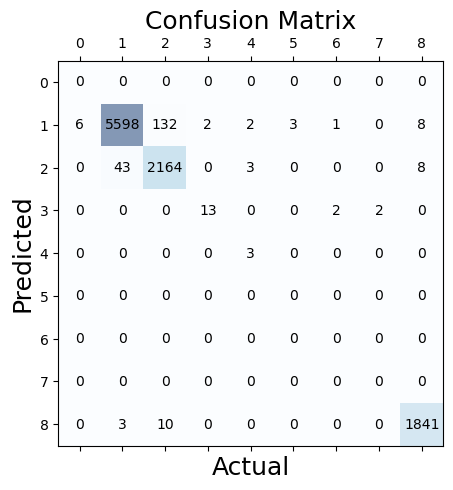

Draft Stage Conf. Mat.


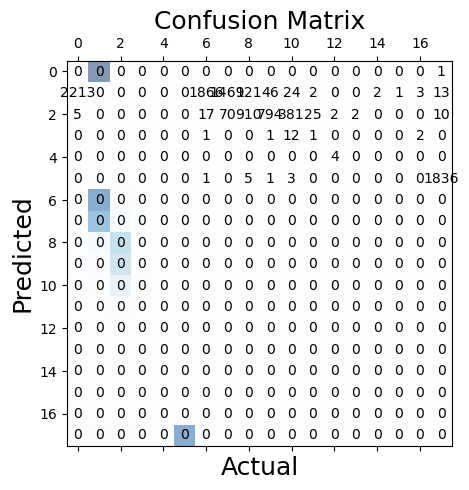

-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TESTING
Draft Round Accuracy = 0.7155627793579845
Draft Stage Accuracy = 0.0
-------------------------------------------------------------------------------------
Draft Round Macro-F1 =  0.2781814899225035
Draft Stage Macro-F1 =  0.0
-------------------------------------------------------------------------------------
Draft Round Conf. Mat.


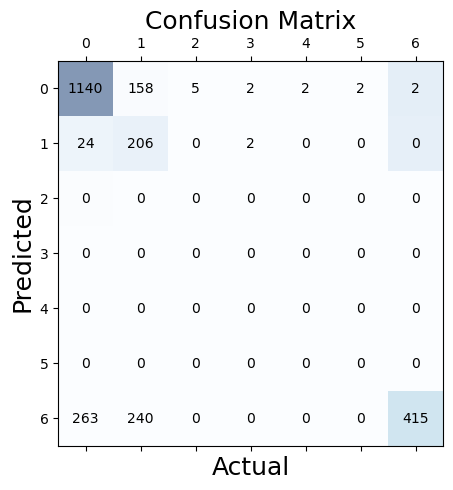

Draft Stage Conf. Mat.


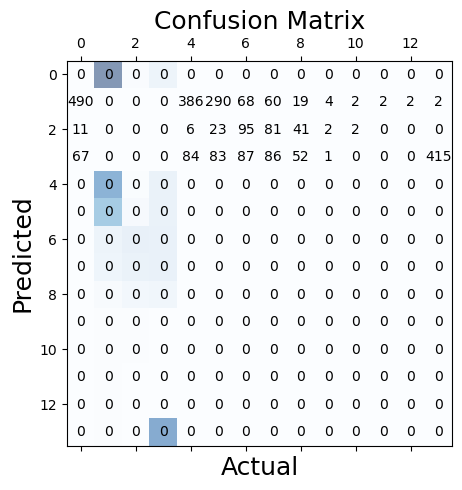

In [29]:
## Results

# Draft Round
mlp_round = MLPClassifier(hidden_layer_sizes=((1024, 512)),\
                alpha=best_params_round['alpha'], learning_rate_init=best_params_round['lr'],\
                max_iter=50, random_state=42,\
                early_stopping=True, validation_fraction=0.1)
mlp_round.out_activation = 'softmax'
mlp_round.fit(np_X_train, np_round_train)

# Draft Stage
mlp_num = MLPClassifier(hidden_layer_sizes=((1024, 512)),\
                alpha=best_params_num['alpha'], learning_rate_init=best_params_num['lr'],\
                max_iter=50, random_state=42,\
                early_stopping=True, validation_fraction=0.1)
mlp_num.out_activation_ = 'softmax'
mlp_num.fit(np_X_train, np_round_train)

print('TRAINING')
round_mlp = mlp_round.predict(np_X_train)
num_mlp = mlp_num.predict(np_X_train)

# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_train, round_mlp)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_train, num_mlp)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_train, round_mlp, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_train, num_mlp, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_train, round_mlp))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_train, num_mlp))
print("-------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------")

print('TESTING')
round_mlp = mlp_round.predict(np_X_test)
num_mlp = mlp_num.predict(np_X_test)

# Accuracy
print(f'Draft Round Accuracy = {accuracy_score(np_round_test, round_mlp)}')
print(f'Draft Stage Accuracy = {accuracy_score(np_num_test, num_mlp)}')
print("-------------------------------------------------------------------------------------")
# Macro F1
print('Draft Round Macro-F1 = ', f1_score(np_round_test, round_mlp, average='macro'))
print('Draft Stage Macro-F1 = ', f1_score(np_num_test, num_mlp, average='macro'))
print("-------------------------------------------------------------------------------------")
# Confusion Matrix
print('Draft Round Conf. Mat.')  
PlotConfMat(confusion_matrix(np_round_test, round_mlp))
print('Draft Stage Conf. Mat.') 
PlotConfMat(confusion_matrix(np_num_test, num_mlp))